# question2

In [1]:
import pandas as pd
import numpy as np
import evaluation
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from fancyimpute import KNN
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

from imblearn.combine import SMOTETomek

from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

/Users/h/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
def read_csv(path_file_name):
    df = pd.read_csv(path_file_name, index_col=False)
    return df

path_file_name= "pokemon_trainer_application_data_numerical.csv" 
df= read_csv(path_file_name)
print(df.shape)
df.head()

(100000, 83)


,ApplicationStatus,ApplicationType,ApplyDate,CurrentlyEmployed,CurrentlyTrainingPokemon,CurrentlyWorkInThisRegion,GraduateSchoolGPA,GraduateSchoolGraduate,GymBadge1Pokemon,GymBadge2Pokemon,...,TotalYearsOfExp,UndergradSchoolGPA,UndergradSchoolGraduate,WorkedInThisRegion,WorkingForJobAppliedFor,hired,RecentTrainingExperience1,RecentTrainingExperience2,RecentTrainingExperience3,team
0,1.0,1,1,1.0,NaN,1.0,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,1.0,NaN,0.0,3288.0,NaN,1277.0,1.0
1,1.0,1,2,2.0,NaN,1.0,NaN,NaN,NaN,NaN,...,5.0,NaN,2.0,1.0,NaN,0.0,122.0,122.0,245.0,1.0
2,1.0,1,3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,5.0,3.0,3.0,1.0,NaN,0.0,NaN,91.0,184.0,1.0
3,1.0,1,4,2.0,NaN,1.0,NaN,NaN,2.0,NaN,...,1.0,2.4,2.0,1.0,NaN,0.0,1308.0,214.0,762.0,1.0
4,2.0,1,4,2.0,NaN,1.0,NaN,NaN,NaN,NaN,...,3.0,3.0,2.0,1.0,NaN,NaN,214.0,243.0,213.0,1.0


#### *these are not  causal features, which only  related to hire appplican. drop them

In [17]:
# these feature is nothing with hired or not, hence delete these feature
cols= ['ApplicationStatus',
       'JobPostingDate',
       'ApplicationType',
       'ApplyDate']
    
for col in cols:
    del df[col]

#### *missing values
listwise deletion: 
1. delete hired feature without label
2. drop columns if over 95% is nan is missing, becuase few info in the colums

In [18]:
# 1. listwise deletion: delete hired feature without label
df= df[df['hired'].notnull()]

# 2. drop columns if 95% is nan is missing, becuase few info in the colums
def drop_col(df, rate_nan):
    total_num= df.shape[0]
    cols_use= []
    print("deleted features: ")
    for n in df.columns:
        num_nan= total_num - len(df[n].dropna())
        rate_num_nan= 1.0*num_nan/total_num
        #print (n, rate_num_nan)
        if rate_num_nan > rate_nan: 
            print("missing values rate:", n, rate_num_nan, "%")
        else:
            cols_use.append(str(n))
            
    df= df[cols_use]
    return df

rate_nan= .95
df= drop_col(df, rate_nan)

deleted feature: 
missing values rate: CurrentlyTrainingPokemon 0.9609534784730225 %
missing values rate: GraduateSchoolGPA 0.9611818814173441 %
missing values rate: GymBadge4Pokemon 0.9818523478784481 %
missing values rate: HiredSalaryOffer 0.9867214833733039 %
missing values rate: OtherSchoolGPA 0.9622823683308935 %


#### *fill missing
knn is better, but take a while
1. set medium
2. use knn set missing values, fill nearest neiborhood

In [5]:
def fill_missing(df, cat='mean'):
    #set medium
    if cat=='mean':  df= df.fillna( df.median() )
    #use knn set missing values, find out nearest neiborhood
    if cat=='knn':   df= pd.DataFrame(KNN(3).fit_transform(df.as_matrix()))
    return df

df= fill_missing(df, 'mean')

#### *From below, datasets is imlabance

0.0    94663
1.0     1658
Name: hired, dtype: int64

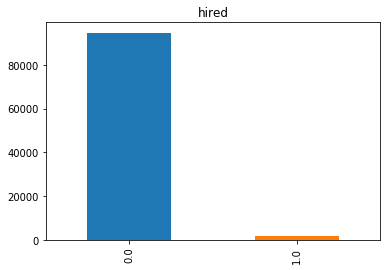

In [6]:
def plot_col_bar(feature, num_bar=2):
    df[feature].value_counts().nlargest(num_bar).plot(kind='bar', title=feature)

plot_col_bar('hired')
df['hired'].value_counts()

In [19]:
def df2array(df):
    df_X= df.drop(['hired'], axis=1)
    
    x_label= df_X.columns.values.tolist()
    X= df_X.as_matrix()
    y= df['hired'].as_matrix()
    return X, x_label, y
X, x_label, y= df2array(df)   

#print(x_label)

/Users/h/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/h/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


#### *handle imbalance datasets 
Combining SMOTE and Tomek acheive best result
1. SMOTE: over-sampling from minority class samples      
2. Tomek: under-sampling from majority class samples   

In [8]:
def resample(X, y):
    print('resapmpling...')
    smt = SMOTETomek(ratio='auto')
    X, y = smt.fit_sample(X, y)

    df_SMOTET= pd.DataFrame(y)
    print(df_SMOTET[0].value_counts())
    print('done')
    return X, y

X,y= resample(X, y)

resapmpling...
1.0    94506
0.0    94506
Name: 0, dtype: int64
done


In [9]:
#split data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### *feature selection
rondom forest as feature selection is relatively good accuracy, robustness and ease of use, particularly some classification tasks

In [38]:
def rank_feature(feature_threshold):
    print("feature importance threthold:", feature_threshold)
    n_estimators= 1000
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1,class_weight="balanced")#10000
    clf.fit(X_train, y_train)
    
    #y_pred = clf.predict(X_test)
    #print( "full feature accuracy: ", accuracy_score(y_test, y_pred) )
    
    r= list(clf.feature_importances_)
    rank= [ (r[i], x_label[i]) for i in range(len(r))]
    rank.sort(reverse=True)
    print("--------------------selected feature-------------------")
    for rk in rank: 
        if rk[0] >= feature_threshold:    print (rk[1], ":", round(rk[0],4) )
            
    print("\n--------------------dropped feature-------------------")            
    for rk in rank: 
        if rk[0] < feature_threshold:    print (rk[1], ":", round(rk[0],4) )            
    
    sfm = SelectFromModel(clf, threshold= feature_threshold)
    sfm.fit(X_train, y_train)

    X_important_train = sfm.transform(X_train)
    X_important_test = sfm.transform(X_test) 
    
    return X_important_train, X_important_test

X_important_train, X_important_test= rank_feature(0.01)

feature importance threthold: 0.01
--------------------selected feature-------------------
TotalYearsOfExp : 0.0963
CurrentlyEmployed : 0.0813
PokemonTrainerClass : 0.0575
JobShiftRotating : 0.0563
JobShiftEvening : 0.0537
JobShiftWeekend : 0.0482
InternalEmployee : 0.0419
JobShiftNight : 0.0393
JobStatusPartTime : 0.0389
UndergradSchoolGraduate : 0.0349
HighEduLevelCompleted : 0.0286
JobSchedule : 0.0275
GymBadgePerm1 : 0.0235
WorkingForJobAppliedFor : 0.0216
ReferenceRelationship2 : 0.0216
ReferenceRelationship1 : 0.0205
PokemonWorldRegion : 0.0201
JobStatusFlexTime : 0.0191
GymCertified : 0.019
team : 0.0149
JobStatusPerDiem : 0.0145
ReferenceRelationship3 : 0.0142
PositionForTrainingPokemon : 0.0118
JobShiftDay : 0.0112
GymBadge1Pokemon : 0.0108
RecentTrainingExperience1PayRateEnd : 0.0105
RecentTrainingExperience1Pokemon : 0.0104

--------------------dropped feature-------------------
JobStatusFullTime : 0.0092
RecentTrainingExperience1 : 0.0087
RecentTrainingExperience1Employment

#### *hired prediction
1. random_forest
2. XGBoost

important feature training
------------------random forest------------------
accuracy: 99.11%
precision: 99.73%
recall: 98.50%
fscore: 99.11%
Confusion matrix:
 [[18671    50]
 [  285 18797]]


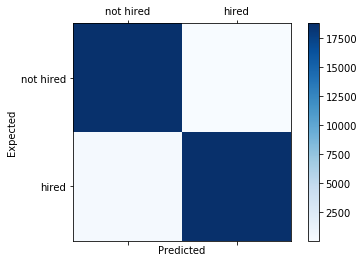

rocauc score: 99.72%


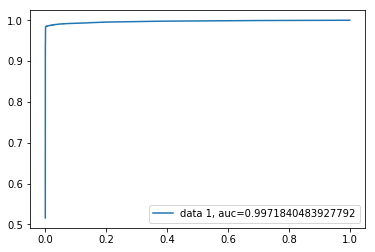

------------------XGBoost------------------


/Users/h/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 98.34%
precision: 98.69%
recall: 97.98%
fscore: 98.33%
Confusion matrix:
 [[18475   246]
 [  381 18701]]


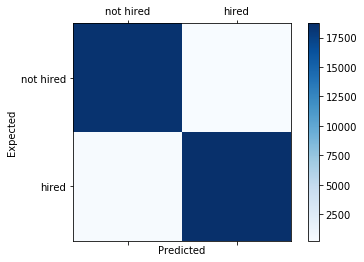

rocauc score: 99.66%


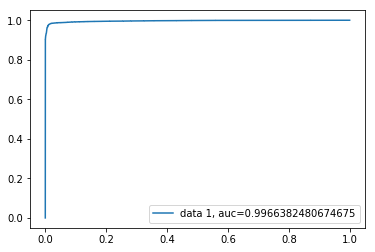

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [39]:
def predict(X_train, X_test, type_model): 
    if type_model == "random_forest":
        print("------------------random forest------------------")
        n_estimators=1000 #10000, roc_auc_score= 0.8
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1, class_weight="balanced")#10000
    if type_model == "XGBoost":
        print("------------------XGBoost------------------")
        model = XGBClassifier()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) #The Full Featured
    prob_y_pred = model.predict_proba(X_test)
    prob_y_pred = [p[1] for p in prob_y_pred]    
    
    evaluation.binary_classification_metrics(y_test, y_pred, 'not hired', 'hired')    
    evaluation.rocauc(y_test, prob_y_pred)

    joblib.dump(model, 'model_saved.joblib')   
    return model

random_forest= "random_forest"
XGBoost= "XGBoost"

"""
print("all features training")
predict(X_train, X_test, random_forest)
predict(X_train, X_test, XGBoost)
"""
print("important feature training")
predict(X_important_train, X_important_test, random_forest)
predict(X_important_train, X_important_test, XGBoost)

# question 3
use datasets train the random foerest model and use model to predict new data.   
step1: save model after training     
step2: load trained model     
step3: use trained model to predict new data       

In [41]:
model = joblib.load('model_saved.joblib') 
one_sample= [X_important_test[0],]
predict= model.predict(one_sample)
predict[0]

/Users/h/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1.0